# Deep Dream Üretme

Deep Dream bir görüntü sınıflandırma modeli almak ve bu girdi için belirli katmanların (ve bazen belirli katmanlardaki belirli birimlerin) aktivasyonlarını en üst düzeye çıkarmak için bir girdi görüntüsü üzerinde gradyan yükselmesş çalıştırmaktan oluşan bir görüntü filtreleme tekniğidir. Halüsinasyon benzeri görseller üretir.

İlk kez Temmuz 2015'te Google'dan Alexander Mordvintsev tarafından tanıtıldı.

**İşlem Adımları :**
* Orijinal görüntüyü yükle
* İşlem sayısını belirle, buna oktav (octaves) diyoruz ve küçükten büyüğe doğru belirlenmelidir.
* Orijinal görüntüyü en küçük skalaya göre yeniden boyutlandır.
* Bütün skalalar için en küçük ten başla:
  + Gradyan yükseliş algoritmasını başlat.
  + Görüntüleri upscale ederek büyüt
  + Yükseltme zamanında kaybolan detayı yeniden düşün
* Orijinal görüntünün boyutuna gelince işlemleri durdur.

Yükseltme sırasında kaybolan ayrıntıyı elde etmek için orijinal görüntüyü alır, küöültür, ölçeklendirir ve sonucu (yeniden boyutlandırılmış) orijinal görüntüyle karşılaştırırız.

### Kütüphanelerin Yüklenmesi ve Giriş Görüntüsünün Okunması

In [229]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

In [230]:
base_image_path = keras.utils.get_file("yeni.jpg", "https://images.unsplash.com/photo-1474418397713-7ede21d49118?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=736&q=80")
result_prefix = "yeni_dream"

In [231]:
# Bunlar aktivasyonu en üst düzeye çıkarmaya çalıştığımız katmanların adları
# ve en üst düzeye çıkarmaya çalıştığımız son kayıptaki ağırlıklardır.

# Yeni görsel efektler elde etmek için bu ayarı düzenleyebiliriz.
layer_settings = {
    "mixed4":2.0,
    "mixed5":3.5,
    "mixed6":1.5,
    "mixed7":4.5,
    "mixed8":3.0,
    "mixed9":5.5
}

In [232]:
# Bu hiperparametrelerle oynamak da yeni efektler elde etmemizi sağlar.

step = 0.01           # Gradyan çıkış adımının boyutu
num_octave = 3        # Gradyan yükselmesinin çalıştırılacağı ölçek sayısı
octave_scale = 1.4    # Ölçekler arasındaki boyut oranı
iterations = 20       # Ölçek başına çıkış adımı sayısı
max_loss = 15.0

In [233]:
# Bu hiperparametrelerle oynamak da yeni efektler elde etmemizi sağlar.

step = 0.015           # Gradyan çıkış adımının boyutu
num_octave = 5        # Gradyan yükselmesinin çalıştırılacağı ölçek sayısı
octave_scale = 1.2    # Ölçekler arasındaki boyut oranı
iterations = 10       # Ölçek başına çıkış adımı sayısı
max_loss = 10.0

**Giriş Görüntüsü :**

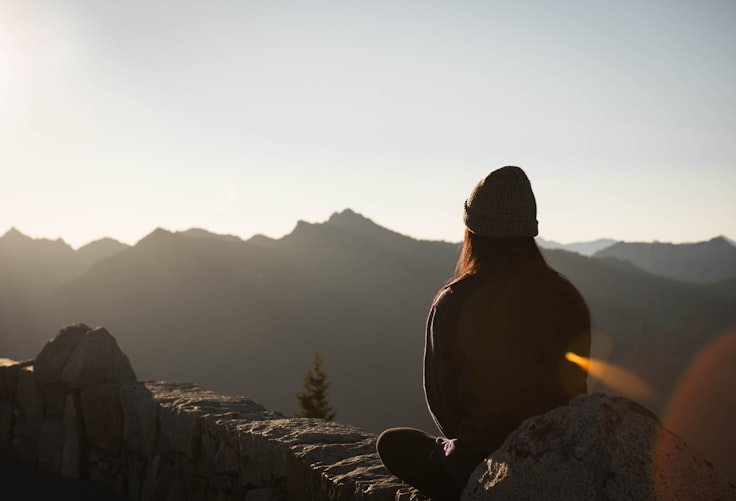

In [234]:
from IPython.display import Image, display
display(Image(base_image_path))

#### Bazı görüntü önişleme / yeniden işleme yardımcı programlarını ayarlayalım :

In [235]:
def preprocess_image(image_path):
    #Resimleri uygun dizilere açmak, yeniden boyutlandırmak ve biçimlendirmek için Util işlevi:
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [236]:
def deprocess_image(x):
    # Numpy dizisini geçerli bir görüntüye dönüştürmek için util işlevi
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Inceptionv3 ön işlemini gei alma
    x /=2.0
    x += 0.5
    x *= 255.0
    # Uint8'e dönüştürme ve geçerli aralığa [0, 255] kırpma
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Deep Dream Kaybını Hesaplama

İlk olarak bir giriş görüntüsü verilen hedef katmanlarımızın aktivasyonunu almak için bir özellik çıkarma modeli oluşturun

In [237]:
# Önceden eğitilmiş ImageNet ağırlıklarıyla dolu bir InceptionV3 modeli oluşturma
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Her anahtar katmanın sembolik çıktılarını almak
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Her hedef katman için etkinleştirme değerlerini döndüren bir model oluşturma (dict olarak)
feature_extractor = keras.Model(inputs=model.inputs, outputs = outputs_dict)

**Gerçek kayıp hesaplaması çok basittir :**

In [238]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Kaybı başlat
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        #Sınırda olmayan pikselleri kayda dahil ederek kenarlık yapaylıklarından kaçınma
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

### Bir oktav için gradyan çıkış döngüsünü ayarlayın.

In [239]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Gradyanları hesaplama
    grads = tape.gradient(loss, img)
    # Gradyanları normalize et
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img

def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss,img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("...loss value at step %d: %.2f" % (i, loss))
    return img

### Farklı oktavlar üzerinde yineleyerek eğitim döngüsünü çalıştırın

In [240]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (241, 354)


/home/dilaver/tf_env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6842']
Received: inputs=Tensor(shape=(1, 241, 354, 3))
  warnings.warn(msg)


...loss value at step 0: 0.44
...loss value at step 1: 0.49
...loss value at step 2: 0.62
...loss value at step 3: 0.76
...loss value at step 4: 0.82
...loss value at step 5: 0.99
...loss value at step 6: 1.08
...loss value at step 7: 1.24
...loss value at step 8: 1.54
...loss value at step 9: 1.54
Processing octave 1 with shape (289, 425)


/home/dilaver/tf_env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6842']
Received: inputs=Tensor(shape=(1, 289, 425, 3))
  warnings.warn(msg)


...loss value at step 0: 0.82
...loss value at step 1: 1.26
...loss value at step 2: 1.70
...loss value at step 3: 1.85
...loss value at step 4: 1.78
...loss value at step 5: 2.44
...loss value at step 6: 2.58
...loss value at step 7: 3.11
...loss value at step 8: 3.65
...loss value at step 9: 3.67
Processing octave 2 with shape (347, 511)


/home/dilaver/tf_env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6842']
Received: inputs=Tensor(shape=(1, 347, 511, 3))
  warnings.warn(msg)


...loss value at step 0: 0.97
...loss value at step 1: 1.63
...loss value at step 2: 1.90
...loss value at step 3: 2.20
...loss value at step 4: 3.07
...loss value at step 5: 3.27
...loss value at step 6: 3.33
...loss value at step 7: 4.26
...loss value at step 8: 4.39
...loss value at step 9: 4.94
Processing octave 3 with shape (417, 613)


/home/dilaver/tf_env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6842']
Received: inputs=Tensor(shape=(1, 417, 613, 3))
  warnings.warn(msg)


...loss value at step 0: 1.06
...loss value at step 1: 1.93
...loss value at step 2: 2.56
...loss value at step 3: 3.19
...loss value at step 4: 3.40
...loss value at step 5: 3.47
...loss value at step 6: 4.29
...loss value at step 7: 4.16
...loss value at step 8: 5.84
...loss value at step 9: 5.81
Processing octave 4 with shape (501, 736)


/home/dilaver/tf_env/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6842']
Received: inputs=Tensor(shape=(1, 501, 736, 3))
  warnings.warn(msg)


...loss value at step 0: 1.22
...loss value at step 1: 1.90
...loss value at step 2: 2.52
...loss value at step 3: 2.65
...loss value at step 4: 3.90
...loss value at step 5: 3.97
...loss value at step 6: 3.94
...loss value at step 7: 4.73
...loss value at step 8: 5.81
...loss value at step 9: 5.85


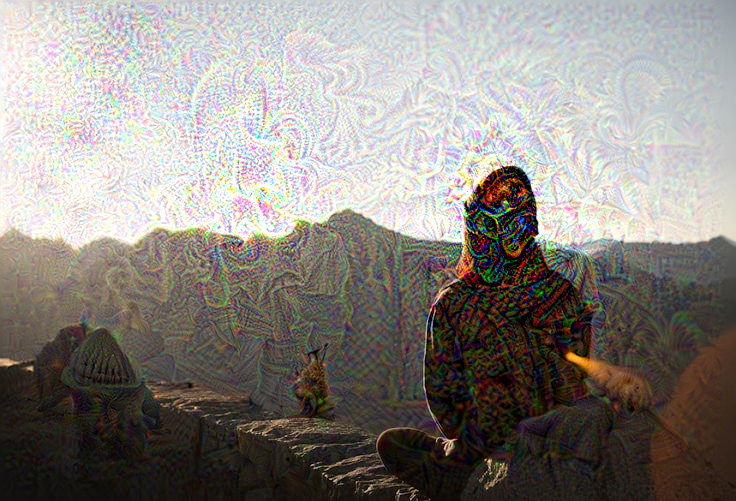

In [241]:
display(Image(result_prefix + ".png"))